In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import umap.plot
import bokeh.plotting
from matplotlib import pyplot as plt

from uriel import Uriel

In [3]:
u = Uriel(load=True, umap=True)

# URIEL insights

Uriel seems to capture the linguistic reality quite realistically. Some interesting features that might speak for URIEL and against genealogical approach:

- Japanic and Koreanic languages are considered to be isolates. Here they are firmly embedded within Sino-Tibetan family. This is probably right, since these languages influence each other for centuries and their functional similarity should be quite high.
- Afro-Asiatic languages are split geographically. Arabic and Berber languages form their own cluster. Other Semitic languages (Ethiosemitic) are closer to Cushitic. And finally Chadic languages are close to Sudanic and Volta-Kongo languages. The family is really spread, but the neighbors make geographical sense each time.
- Uralic languages are closer to European languages than Indo-Iranian or Indo-Aryan languages. Perhaps the georgraphical similarity make them functionally similar again? In [Rahimi 2019] Finnish and Hungarian behave similarly to all the other European languages, while Indo-Iranian/Aryan languages have much worse performance. But it is possible that the difference is caused by different alphabets, since Cyrilic languages also fall behind. Comparing Uralic and non-IE languages with Latin alphabet is also slightly in favor of Uralic languages. Vietnamese, Tagalog or Indonesian all have Latin alphabet, but worse results.

In [7]:
p = umap.plot.interactive(
    u.umap_vectors,
    labels=u.language_metadata()['label'],
    hover_data=u.language_metadata(),
    width=600,
    height=600,
    interactive_text_search=True,
    point_size=3,
    interactive_text_search_alpha_contrast=0.99,
    theme='blue',
)
bokeh.plotting.output_notebook() 
bokeh.plotting.show(p)

Loading BokehJS ...

In [ ]:
umap.plot.connectivity(trans, show_points=True, edge_bundling='hammer')

# Language Similarities

Histogram below shows how similar are langauges in general. It seems to follow the normal distribution with mean $\sim0.65$. There are some artefacts near the mean, I was not able to find out how they came to be. It is also weird that there are only 55 overal values for norms, even though we have 289 features. Perhaps this is a result of KNN being applied to fill some values?

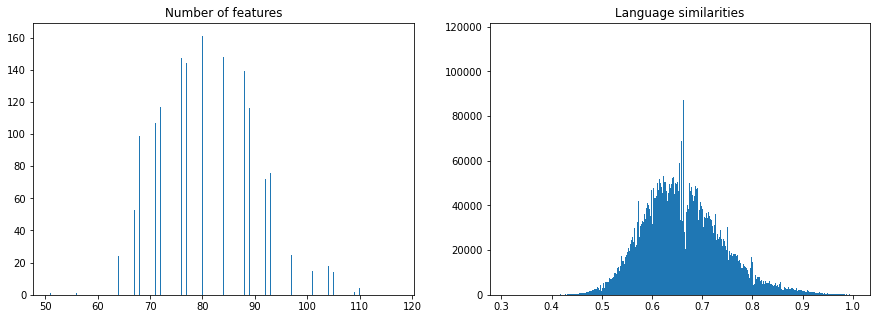

In [129]:
plt.rcParams["figure.figsize"] = (15,5)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(np.sum(u.knn_matrix, axis=1), 1000)
ax1.set_title('Number of features')
normalized = u.knn_matrix / np.linalg.norm(u.knn_matrix, axis=1).reshape(-1, 1)
ax2.hist((normalized @ normalized.T).reshape(-1), 1000) 
ax2.set_title('Language similarities')
plt.show() 

In [4]:
# import lang2vec.lang2vec as l2v

# languages = [
#     line.split()[0]
#     for line
#     in open('./papers/rahimi_ner.txt')
# ]

# switch = {
#     'ar': 'arb',
#     'fa': 'pes',
#     'sq': 'als',
#     'ms': 'zlm'
# }

# languages = [
#     switch[l] if l in switch else l2v.LETTER_CODES[l]
#     for l
#     in languages
# ]

languages = ['afr', 'arb', 'bul', 'ben', 'bos', 'cat', 'ces', 'dan', 'deu', 'ell', 'spa', 'est', 'pes', 'fin', 'fra', 'heb', 'hin', 'hrv', 'hun', 'ind', 'ita', 'lit', 'lav', 'mkd', 'zlm', 'nld', 'nor', 'pol', 'por', 'ron', 'rus', 'slk', 'slv', 'als', 'swe', 'tam', 'tgl', 'tur', 'ukr', 'vie']

In [5]:
def show_weights(weights):
    max_ = max(weights.values())
    metadata = u.language_metadata()
    p = umap.plot.interactive(
        u.umap_vectors,
        hover_data=metadata,
        width=600,
        height=600,
        interactive_text_search=True,
        point_size=2,
        interactive_text_search_alpha_contrast=0.99,
    )
    metadata = metadata[metadata['code'].isin(weights)]
    metadata = hvr.assign(
        x=u.umap_vectors.embedding_[hvr.index][:,0],
        y=u.umap_vectors.embedding_[hvr.index][:,1],
        width=0.05,
        height=[weights[l]*5/max_ for l in hvr['code']],
        alpha=1,
    )
    hvr['y'] += hvr['height'] / 2
    p.children[1].rect(
        x='x',
        y='y',
        width='width',
        height='height',
        color="#ee6666",
        source=metadata,
    s)

    bokeh.plotting.output_notebook() 
    bokeh.plotting.show(p)

# Different similarity measures

I implemented three similarity measures: Euclidean similarity, cosine similarity and Jaccard-like similarity. From these cosine similarity seems to be the best. It seems to be the most stable, other measure have some artifacts (e.g. see scores for French or difference between Arabic and Hebrew).

In [6]:
show_weights(u.weights(languages, temperature=15, measure='cos'))

Loading BokehJS ...

In [148]:
show_weights(u.weights(languages, temperature=1, measure='euc'))

Loading BokehJS ...

In [150]:
show_weights(u.weights(languages, temperature=15, measure='jac'))

Loading BokehJS ...

# URIEL features

In [9]:
import lang2vec.lang2vec as l2v
# syntax = 103
# inventory = 158
# phonology = 28
l2v.get_features('en', 'syntax_knn', header=True)['CODE']

['S_SVO',
 'S_SOV',
 'S_VSO',
 'S_VOS',
 'S_OVS',
 'S_OSV',
 'S_SUBJECT_BEFORE_VERB',
 'S_SUBJECT_AFTER_VERB',
 'S_OBJECT_AFTER_VERB',
 'S_OBJECT_BEFORE_VERB',
 'S_SUBJECT_BEFORE_OBJECT',
 'S_SUBJECT_AFTER_OBJECT',
 'S_GENDER_MARK',
 'S_SEX_MARK',
 'S_DEFINITE_AFFIX',
 'S_DEFINITE_WORD',
 'S_INDEFINITE_AFFIX',
 'S_INDEFINITE_WORD',
 'S_POSSESSIVE_PREFIX',
 'S_POSSESSIVE_SUFFIX',
 'S_ADPOSITION_BEFORE_NOUN',
 'S_ADPOSITION_AFTER_NOUN',
 'S_POSSESSOR_BEFORE_NOUN',
 'S_POSSESSOR_AFTER_NOUN',
 'S_ADJECTIVE_BEFORE_NOUN',
 'S_ADJECTIVE_AFTER_NOUN',
 'S_DEMONSTRATIVE_WORD_BEFORE_NOUN',
 'S_DEMONSTRATIVE_WORD_AFTER_NOUN',
 'S_DEMONSTRATIVE_PREFIX',
 'S_DEMONSTRATIVE_SUFFIX',
 'S_NUMERAL_BEFORE_NOUN',
 'S_NUMERAL_AFTER_NOUN',
 'S_RELATIVE_BEFORE_NOUN',
 'S_RELATIVE_AFTER_NOUN',
 'S_RELATIVE_AROUND_NOUN',
 'S_NOMINATIVE_VS_ACCUSATIVE_MARK',
 'S_ERGATIVE_VS_ABSOLUTIVE_MARK',
 'S_NEGATIVE_WORD_BEFORE_VERB',
 'S_NEGATIVE_PREFIX',
 'S_NEGATIVE_WORD_AFTER_VERB',
 'S_NEGATIVE_SUFFIX',
 'S_NEGATIVE_WOR

In [10]:
l2v.get_features('en', 'inventory_knn', header=True)['CODE']

['INV_OPEN_FRONT_UNROUNDED_VOWEL',
 'INV_VOICED_BILABIAL_PLOSIVE',
 'INV_VOICED_BILABIAL_PLOSIVE_WITH_VOICED_LABIODENTAL_FRICATIVE',
 'INV_VOICED_BILABIAL_PLOSIVE_WITH_VOICED_BILABIAL_FRICATIVE',
 'INV_VOICELESS_PALATAL_PLOSIVE',
 'INV_VOICELESS_PALATAL_PLOSIVE_WITH_VOICELESS_PALATAL_FRICATIVE',
 'INV_VOICED_ALVEOLAR_PLOSIVE',
 'INV_VOICED_ALVEOLAR_PLOSIVE_WITH_VOICED_DENTAL_FRICATIVE',
 'INV_VOICED_ALVEOLAR_PLOSIVE_WITH_VOICED_ALVEOLAR_LATERAL_FRICATIVE',
 'INV_VOICED_ALVEOLAR_PLOSIVE_WITH_VOICED_ALVEOPALATAL_FRICATIVE',
 'INV_VOICED_ALVEOLAR_PLOSIVE_WITH_VOICED_POSTALVEOLAR_FRICATIVE',
 'INV_CLOSE_MID_FRONT_UNROUNDED_VOWEL',
 'INV_VOICELESS_LABIODENTAL_FRICATIVE',
 'INV_VOICELESS_GLOTTAL_FRICATIVE',
 'INV_CLOSE_FRONT_UNROUNDED_VOWEL',
 'INV_PALATAL_APPROXIMANT',
 'INV_VOICELESS_VELAR_PLOSIVE',
 'INV_VOICELESS_VELAR_PLOSIVE_WITH_VOICELESS_BILABIAL_PLOSIVE',
 'INV_VOICELESS_VELAR_PLOSIVE_WITH_VOICELESS_VELAR_FRICATIVE',
 'INV_ALVEOLAR_LATERAL_APPROXIMANT',
 'INV_BILABIAL_NASAL',
 'INV_

In [11]:
l2v.get_features('en', 'phonology_knn', header=True)['CODE']

['P_VOICE',
 'P_VOICED_PLOSIVES',
 'P_VOICED_FRICATIVES',
 'P_EJECTIVES',
 'P_IMPLOSIVES',
 'P_GLOTTALIZED_RESONANTS',
 'P_UVULARS',
 'P_UVULAR_STOPS',
 'P_UVULAR_CONTINUANTS',
 'P_LATERALS',
 'P_LATERAL_L',
 'P_LATERAL_OBSTRUENTS',
 'P_NASAL_VOWELS',
 'P_FRONT_ROUND_VOWELS',
 'P_BILABIALS',
 'P_FRICATIVES',
 'P_NASALS',
 'P_LABIAL_VELARS',
 'P_CLICKS',
 'P_TH',
 'P_PHARYNGEALS',
 'P_COMPLEX_ONSETS',
 'P_TONE',
 'P_VELAR_NASAL',
 'P_VELAR_NASAL_INITIAL',
 'P_CODAS',
 'P_COMPLEX_CODAS',
 'P_LONG_VOWELS']